In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split

from shapkit.shapley_values import ShapleyValues
from shapkit.inspector import inspector
from shapkit.monte_carlo_shapley import MonteCarloShapley
from shapkit.sgd_shapley import SGDshapley
from shapkit.plots import plot_shapley

%load_ext autoreload
%autoreload 2

In [2]:
try:
    from catboost import CatBoostRegressor, Pool
except:
    ! pip install catboost 

# Load dataset

In [3]:
df = pd.read_csv("../dataset/bike/hour.csv")
df = df.drop(columns=["instant", "dteday", "yr"])
cat_features = ["season", "mnth", "hr", "holiday", "weekday", "workingday", "weathersit"]
df[cat_features] = df[cat_features].astype("str")
df.head(3)

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,1,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,1,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


In [4]:
target_names = 'cnt'
columns = [col for col in df.columns if col != target_names]
X = df[columns].copy()
y = df[target_names].copy()

In [5]:
d = X.shape[1]
n = 2**d - 2
d, n

(13, 8190)


# Train a ML model

In [6]:
cat_features_index = [i for i, col in enumerate(X.columns) if col in cat_features]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.33,
                                                  random_state=42)
test_data = catboost_pool = Pool(X_test, y_test,
                                 cat_features=cat_features_index)
val_data = catboost_pool = Pool(X_val, y_val,
                                cat_features=cat_features_index)
model = CatBoostRegressor(iterations=1000, depth=3,
                           learning_rate=1,
                           loss_function='RMSE',
                           verbose=100)
# train the model
model.fit(X_train, y_train,
          cat_features=cat_features_index,
          eval_set=val_data)

# make the prediction using the resulting model
preds = model.predict(test_data)
rmse = np.sqrt(np.mean((preds - y_test)**2))
print("Test RMSE: {0:.2}".format(rmse))

0:	learn: 72.0079582	test: 68.8890183	best: 68.8890183 (0)	total: 73.7ms	remaining: 1m 13s
100:	learn: 3.3868955	test: 4.0279568	best: 3.9496225 (95)	total: 1.29s	remaining: 11.5s
200:	learn: 2.2990130	test: 3.3573326	best: 3.3573326 (200)	total: 2.5s	remaining: 9.94s
300:	learn: 1.8800424	test: 3.2616370	best: 3.2345658 (291)	total: 3.68s	remaining: 8.54s
400:	learn: 1.6002957	test: 3.1736670	best: 3.1580785 (393)	total: 4.8s	remaining: 7.18s
500:	learn: 1.4201456	test: 3.1613384	best: 3.1245929 (474)	total: 5.89s	remaining: 5.87s
600:	learn: 1.2939205	test: 3.1592655	best: 3.1245929 (474)	total: 6.84s	remaining: 4.54s
700:	learn: 1.1926415	test: 3.1446594	best: 3.1245929 (474)	total: 7.82s	remaining: 3.33s
800:	learn: 1.0794685	test: 3.1767016	best: 3.1245929 (474)	total: 8.84s	remaining: 2.2s
900:	learn: 1.0107002	test: 3.1520059	best: 3.1245929 (474)	total: 10.1s	remaining: 1.11s
999:	learn: 0.9582450	test: 3.1601631	best: 3.1245929 (474)	total: 11.4s	remaining: 0us

bestTest = 3.1

# Define the reward function

In [7]:
fc = lambda x: model.predict(x)

# Pick an individual x to explain

In [8]:
x = X_test.iloc[np.random.choice(len(X_test), size=1)[0],:]
print(x)
print()
print("Prediction for x: {0:.0f}".format(model.predict(x.values)))

season             2
mnth               6
hr                17
holiday            0
weekday            4
workingday         1
weathersit         1
temp             0.9
atemp         0.8182
hum             0.37
windspeed     0.2537
casual            54
registered       355
Name: 3739, dtype: object

Prediction for x: 406


# Single reference

In [9]:
reference = X_train.iloc[np.random.choice(len(X_train), size=1)[0],:]
print(reference)
print()
print("Prediction for this reference: {0:.0f}".format(model.predict(reference.values)))

season             4
mnth               9
hr                 2
holiday            0
weekday            5
workingday         1
weathersit         3
temp             0.6
atemp         0.5455
hum             0.88
windspeed     0.2985
casual             1
registered         9
Name: 15141, dtype: object

Prediction for this reference: 10


# Exact Shapley Values

In [10]:
true_shap = ShapleyValues(x=x, fc=fc, ref=reference)

100%|██████████| 13/13 [01:52<00:00,  8.63s/it]


In [11]:
true_shap

season         -0.075781
mnth            0.266232
hr              0.536660
holiday         0.000000
weekday        -0.534814
workingday      0.000000
weathersit     -0.154479
temp           -0.481732
atemp           1.202777
hum            -0.471824
windspeed      -0.101771
casual         53.680650
registered    341.897188
dtype: float64

# Approximation methods

## Monte Carlo 

In [12]:
mc_shap = MonteCarloShapley(x=x, fc=fc, ref=reference, n_iter=1000)
mc_shap

  1%|          | 6/1000 [00:00<00:17, 57.60it/s]

new dimension 11


100%|██████████| 1000/1000 [00:13<00:00, 76.12it/s]


season         -0.099420
mnth            0.261289
hr              0.546706
holiday         0.000000
weekday        -0.541990
workingday      0.000000
weathersit     -0.152011
temp           -0.471143
atemp           1.232937
hum            -0.451269
windspeed      -0.101771
casual         53.682976
registered    341.856801
dtype: float64

## SGD

In [13]:
sgd_est = SGDshapley(d, C=y.max())
sgd_shap = sgd_est.sgd(x=x, fc=fc, ref=reference, n_iter=5000, step=.1, step_type="sqrt")
sgd_shap

100%|██████████| 5000/5000 [00:04<00:00, 1084.89it/s]


season          0.845042
mnth           -1.484094
hr              0.994556
holiday         0.305818
weekday        -0.201076
workingday      0.732353
weathersit     -0.004385
temp            1.093825
atemp           2.171227
hum             0.379495
windspeed       0.550705
casual         55.144499
registered    335.235140
dtype: float64

# Plot 

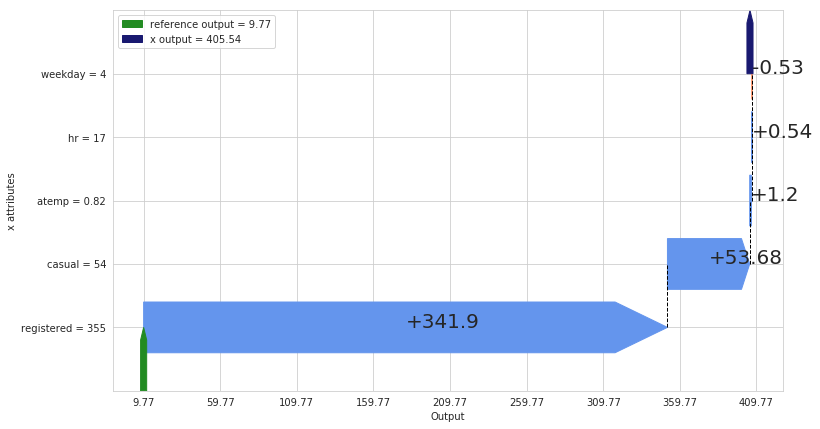

In [14]:
plot_shapley(x=x, fc=fc, ref=reference, shapley_values=true_shap, n_attributes=5)

# Several references 

In [15]:
n_ref = 100
idx_ref = np.random.choice(X_train.shape[0], size=n_ref, replace=False).flatten()
references = X_train.iloc[idx_ref]
references.head(5)

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered
4940,3,7,18,0,5,1,1,0.92,0.8636,0.37,0.3284,49,313
2317,2,4,11,0,1,1,2,0.60,0.5909,0.73,0.2985,45,59
12567,2,6,20,0,2,1,1,0.68,0.6364,0.83,0.1940,36,350
9513,1,2,8,0,1,1,1,0.16,0.1818,0.86,0.1343,10,434
3899,2,6,9,0,4,1,2,0.62,0.6061,0.65,0.1940,29,232


# Approximation methods

## Monte Carlo 

In [16]:
mc_shaps = MonteCarloShapley(x=x, fc=fc, ref=references, n_iter=10000)
mc_shaps

100%|██████████| 10000/10000 [01:59<00:00, 83.91it/s]


season         -0.141238
mnth            0.305030
hr              0.385498
holiday        -0.000457
weekday        -0.050993
workingday      0.000000
weathersit     -0.025006
temp           -0.492004
atemp           0.983451
hum            -0.509046
windspeed      -0.198035
casual         20.524242
registered    184.994383
dtype: float64

# Plots

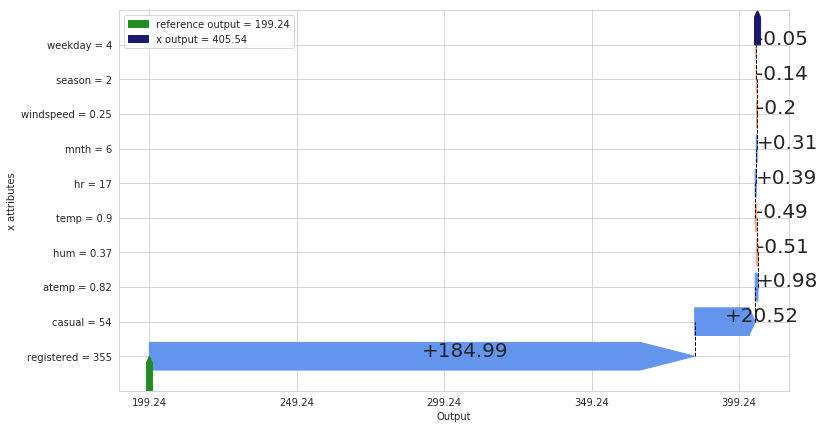

In [17]:
plot_shapley(x=x, fc=fc, ref=references, shapley_values=mc_shaps, n_attributes=10)